In [6]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

import pandas as pd
import numpy as np
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
data=pd.read_csv("bike sharing hour.csv")
print(data.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


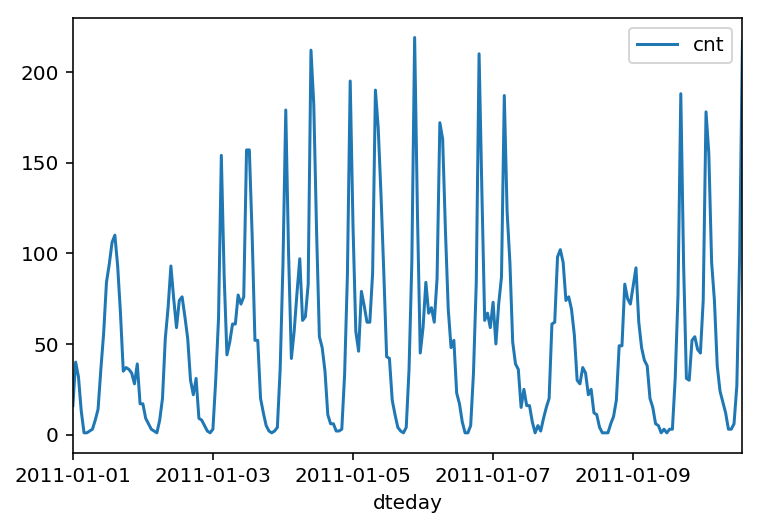

In [7]:
data[:24*10].plot(x='dteday', y='cnt')

In [8]:
dummy_fields = ['season', 'weathersit', 'mnth', 'hr', 'weekday']
for each in dummy_fields:
    dummies = pd.get_dummies(data[each], prefix=each, drop_first=False)
    data = pd.concat([data, dummies], axis=1)

fields_to_drop = ['instant', 'dteday', 'season', 'weathersit', 
                  'weekday', 'atemp', 'mnth', 'workingday', 'hr']
datas = data.drop(fields_to_drop, axis=1)
datas.head()

,yr,holiday,temp,hum,windspeed,casual,registered,cnt,season_1,season_2,...,hr_21,hr_22,hr_23,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
0,0,0,0.24,0.81,0.0,3,13,16,1,0,...,0,0,0,0,0,0,0,0,0,1
1,0,0,0.22,0.80,0.0,8,32,40,1,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,0.22,0.80,0.0,5,27,32,1,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0.24,0.75,0.0,3,10,13,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0.24,0.75,0.0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [9]:
quant_features = ['casual', 'registered', 'cnt', 'temp', 'hum', 'windspeed']
# Store scalings in a dictionary so we can convert back later
scaled_features = {}
for each in quant_features:
    mean, std = data[each].mean(), data[each].std()
    scaled_features[each] = [mean, std]
    data.loc[:, each] = (data[each] - mean)/std
print(scaled_features)

{'casual': [35.67621842453536, 49.305030387053186], 'registered': [153.78686920996606, 151.35728591258317], 'cnt': [189.46308763450142, 181.38759909186527], 'temp': [0.4969871684216586, 0.19255612124972407], 'hum': [0.6272288394038822, 0.1929298340629125], 'windspeed': [0.1900976063064631, 0.12234022857279413]}


In [10]:
test_data = data[-21*24:]

# Now remove the test data from the data set 
data = data[:-21*24]

# Separate the data into features and targets
target_fields = ['cnt', 'casual', 'registered']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
train_features, train_targets = features[:-60*24], targets[:-60*24]
val_features, val_targets = features[-60*24:], targets[-60*24:]

In [11]:
data=pd.concat([features,targets],axis=1)
data2=data.corr('pearson')

In [12]:
data2
abs(data2.loc['cnt']).sort_values(ascending=False)

cnt             1.000000
registered      0.971892
casual          0.697137
temp            0.404798
atemp           0.400787
                  ...   
weathersit_4    0.008536
mnth_4          0.006106
weekday_6       0.003573
weekday_3       0.003050
weekday_2       0.002151
Name: cnt, Length: 67, dtype: float64

In [13]:
X1=data['registered']
X2=data['casual']
Y=data['cnt']

In [14]:
X1 = np.array((X1 - X1.min())/(X1.max() - X1.min()))
X2 = np.array((X2 - X2.min())/(X2.max() - X2.min()))
Y = np.array((Y - Y.min())/(Y.max() - Y.min()))

In [15]:
from sklearn.model_selection import train_test_split
x1_train, x1_test, x2_train, x2_test, y_train, y_test = train_test_split(X1, X2, Y, test_size=0.2)

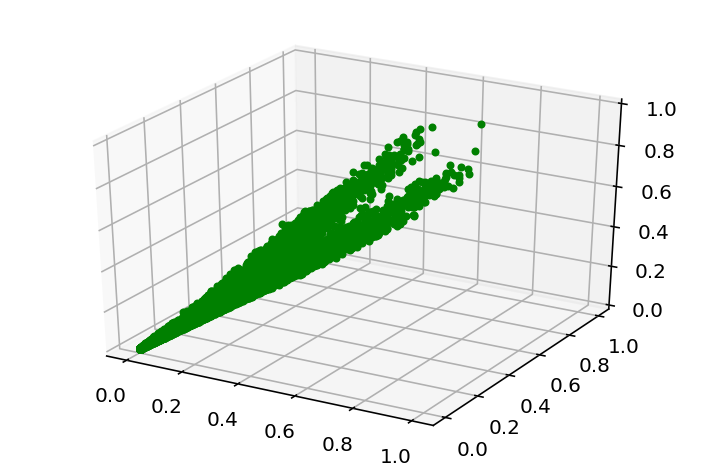

In [16]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot(x1_train, x2_train, y_train, 'g.')

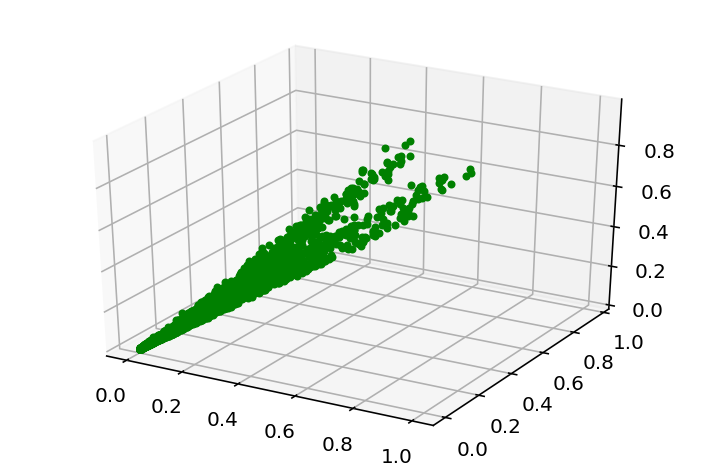

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(x1_test, x2_test, y_test, 'g.')

In [18]:
def hypothesis(a,b,c,x1,x2):
    return a * x1 + b * x2 + c

In [19]:
def error(a,b,c,x1,x2,y):
    e = 0
    m = len(x1)
    for i in range(m):
        e += np.power((hypothesis(a,b,c,x1[i],x2[i]) - y[i]), 2)
    
    return (1/(2*m)) * e

In [20]:
def step_gradient(a,b,c,x1,x2,y,learning_rate):
    grad_a = 0
    grad_b = 0
    grad_c = 0
    m = len(x1)
    for i in range(m):
        grad_a += 2/m * (hypothesis(a,b,c,x1[i],x2[i]) - y[i]) * x1[i]
        grad_b += 2/m * (hypothesis(a,b,c,x1[i],x2[i]) - y[i]) * x2[i]
        grad_c += 2/m * (hypothesis(a,b,c,x1[i],x2[i]) - y[i])
        
    a = a - (grad_a * learning_rate)
    b = b - (grad_b * learning_rate)
    c = c - (grad_c * learning_rate)
    
    return a, b, c

In [21]:
def descend(initial_a, initial_b, initial_c, x1, x2, y, learning_rate, iterations):
    a = initial_a
    b = initial_b
    c = initial_c
    for i in range(iterations):
        e = error(a, b, c, x1, x2, y)
        if i % 1000 == 0:
            print(f"Error: {e}, a: {a}, b: {b}, c: {c}")
        
        a, b, c = step_gradient(a, b, c, x1, x2, y, learning_rate)

    return a, b, c

In [22]:
a = 0
b = 1
c = 1
learning_rate = 0.01
iterations = 9000

final_a, final_b, final_c = descend(a, b, c, x1_train, x2_train, y_train, learning_rate, iterations)

Error: 0.41823965892912796, a: 0, b: 1, c: 1
Error: 0.005354722478050173, a: 0.211035610549254, b: 0.9088197600142996, c: 0.06984078070400247
Error: 0.0028014341868164033, a: 0.4253984984061939, b: 0.8546589514137111, c: 0.03672973682904969
Error: 0.00165128290195081, a: 0.5581519594057766, b: 0.7854187294652155, c: 0.019902365738246827
Error: 0.001028454499069028, a: 0.6454581095894604, b: 0.7171640846149752, c: 0.011176427501975842
Error: 0.0006550680478410306, a: 0.7061165873256487, b: 0.6561278030103684, c: 0.006516528011472027
Error: 0.0004208639759392351, a: 0.7502030717783408, b: 0.6040439924382444, c: 0.003925399092984089
Error: 0.0002712773385930609, a: 0.7833467956459351, b: 0.5607002523880442, c: 0.002408880468602455
Error: 0.00017507145792329643, a: 0.8088613009253051, b: 0.5251382936865373, c: 0.0014676300463403876


In [24]:
print(error(a,b,c,x1_train,x2_train,y_train))
print(error(final_a, final_b, final_c,x1_train,x2_train, y_train))
print(error(final_a, final_b, final_c,x1_test,x2_test, y_test))

0.41823965892912796
0.00011303552071513886
0.00010867819897236703


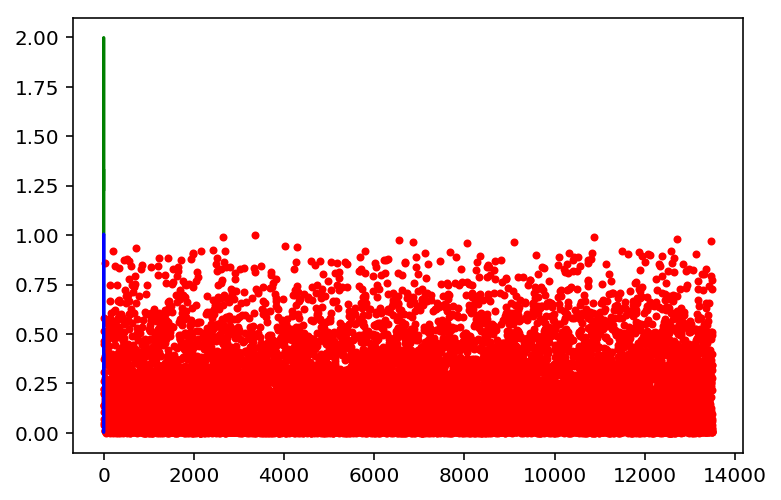

In [28]:
plt.plot(x1_train,x2_train, y_train, 'r.', x1_train, hypothesis(a, b, c,x1_train,x2_train), 'g', x2_train, hypothesis(final_a, final_b,final_c,x1_train, x2_train), 'b', )

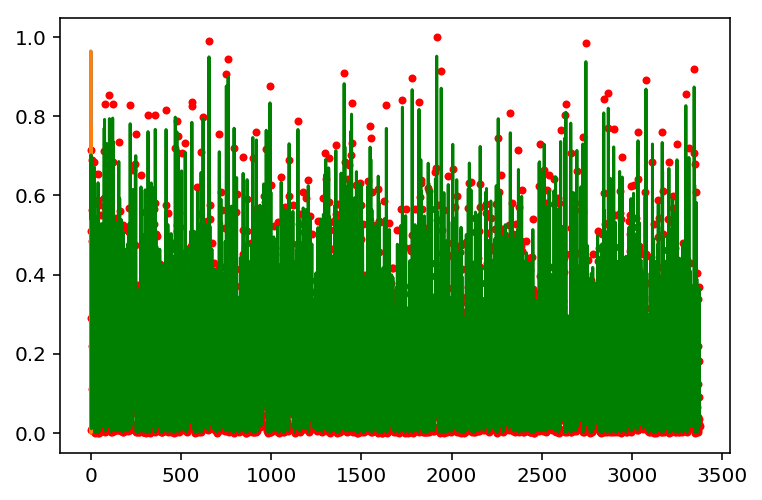

In [29]:
plt.plot(x1_test,x2_test, y_test, 'r.', x1_test,x2_test, hypothesis(final_a, final_b,final_c, x1_test,x2_test), 'g')

In [30]:
print(str((1-error(final_a,  final_b,final_c, x1_test,x2_test, y_test))*100) + " %")

99.98913218010277 %
